In [1]:
import re # regex
import pandas as pd # tables
import matplotlib.pyplot as plt # plots
import seaborn as sns # plots
import numpy as np # operations with arrays and matrices 
import tensorflow as tf
from sklearn import metrics

                                               Input Sentiment
0                                   i feel so guilty   sadness
1            i am feeling quite anxious about it all      fear
2              im feeling a little smug this evening       joy
3  one of my very good friends came to me for adv...     anger
4  i feel about the scratches the way i feel abou...     trust


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


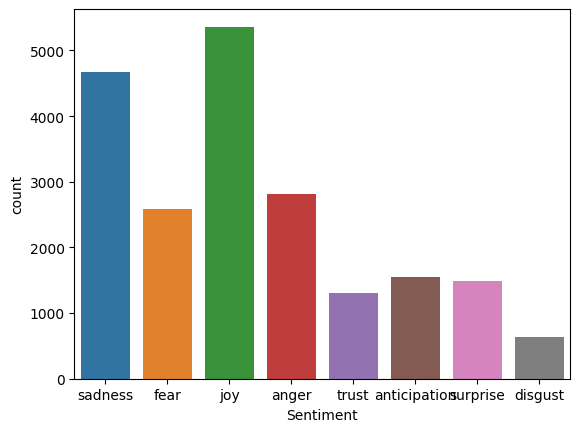

In [2]:
train = pd.read_csv(f"final_train.csv", encoding='utf-8')
test = pd.read_csv(f"final_test.csv", encoding='utf-8')
validation = pd.read_csv(f"final_validate.csv", encoding='utf-8')

train['Input'] = train['Input'].replace('love', 'trust')
test['Input'] = test['Input'].replace('love', 'trust')
validation['Input'] = validation['Input'].replace('love', 'trust')

# train = pd.read_csv('train.txt', header =None, sep =';', names = ['Input','Sentiment'], encoding='utf-8')

# test = pd.read_csv('test.txt', header = None, sep =';', names = ['Input','Sentiment'],encoding='utf-8')

# validation = pd.read_csv('val.txt',header=None,sep=';', names=['Input','Sentiment'], encoding='utf-8')

print(train.head())
sns.countplot(train, x='Sentiment')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


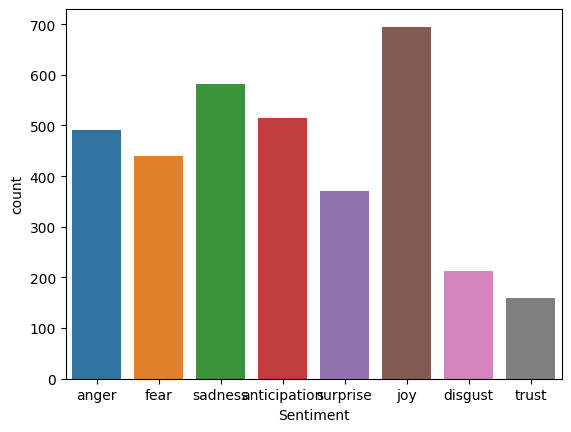

In [3]:
sns.countplot(test, x='Sentiment')
plt.show()

In [4]:
# adding a column with encoded emotions
emotions_to_labels = {'anger': 0, 'love': 1, 'fear': 2, 'joy': 3, 'sadness': 4,'surprise': 5}
labels_to_emotions = {j:i for i,j in emotions_to_labels.items()}

train['Labels'] = train.Sentiment.map(emotions_to_labels)
test['Labels'] = test.Sentiment.map(emotions_to_labels)
validation['Labels'] = validation.Sentiment.map(emotions_to_labels)

In [5]:
train.Sentiment.unique()

array(['sadness', 'fear', 'joy', 'anger', 'trust', 'anticipation',
       'surprise', 'disgust'], dtype=object)

In [6]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(train.Labels)
y_test = to_categorical(test.Labels)
y_validation = to_categorical(validation.Labels)

# Step 1 Preprocessing
---

In [7]:
import nltk 
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from collections import Counter
# downloading a set of stop-words
STOPWORDS = set(stopwords.words('english'))

# tokenizer
from nltk.tokenize import word_tokenize

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:992)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:992)>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify
[nltk_data]     failed: unable to get local issuer certificate
[nltk_data]     (_ssl.c:992)>


In [8]:
def text_preprocess(text, stop_words=True): #Always set stopwords to true
    '''
    Accepts text (a single string) and
    a parameters of preprocessing
    Returns preprocessed text
    '''
    # clean text from non-words
    text = re.sub(r'\W+', ' ', text).lower()
    
    # tokenize the text
    tokens = word_tokenize(text)
    
    if stop_words:
        # delete stop_words
        tokens = [token for token in tokens if token not in STOPWORDS]
    
    tokens = ' '.join(tokens)
    return tokens

train_new = train.Input.apply(text_preprocess)
test_new = test.Input.apply(text_preprocess)
validation_new = validation.Input.apply(text_preprocess)

In [9]:
train_new

0                                              feel guilty
1                                    feeling quite anxious
2                           im feeling little smug evening
3        one good friends came advice boyfriend hitting...
4        feel scratches way feel wrinkles fond regard e...
                               ...                        
20375    want savor feeling ecstatic anticipation abide...
20376    im feeling puppy dogs rainbows im exhausted ye...
20377                                        feel delicate
20378                        starting feel little stressed
20379             feel stressed tired worn shape neglected
Name: Input, Length: 20380, dtype: object

# Experiment 1: Benchmarking with Feature Engineering by TF-IDF
---
https://medium.com/@saurabhsingh_23777/multi-class-text-classification-text-transformations-and-model-performance-comparison-dc06ff33a532

In [10]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.utils import class_weight

# sublinear_df is set to True to use a logarithmic form for frequency
# min_df is the minimum numbers of documents a word must be present in to be kept
# ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams

train_exp_1 = train_new.copy()
test_exp_1 = test_new.copy()
validation_exp_1 = validation_new.copy()
tfidf = TfidfVectorizer(sublinear_tf=True,min_df=5,ngram_range=(1, 2))
tfidf.fit(train_exp_1)
train_exp_1 =  tfidf.transform(train_exp_1)
test_exp_1 =  tfidf.transform(test_exp_1)
validation_exp_1 =  tfidf.transform(validation_exp_1)

In [11]:
print(train_exp_1.shape)
print(test_exp_1.shape)
print(validation_exp_1.shape)

(30700, 8548)
(16700, 8548)
(16700, 8548)


In [12]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(multi_class='multinomial',solver='newton-cg',n_jobs=1, C=1e5)
logreg.fit(train_exp_1, train.Labels) #use the train labels and not the categorical labelling
pred_y = logreg.predict(test_exp_1)

KeyboardInterrupt: 

In [219]:
print('accuracy %s' % metrics.accuracy_score(pred_y, test.Labels))
print(metrics.classification_report(test.Labels, pred_y))

accuracy 0.8937234042553192
              precision    recall  f1-score   support

           0       0.84      0.83      0.84      2775
           2       0.88      0.89      0.89      3224
           3       0.90      0.83      0.87       695
           4       0.91      0.81      0.85       581
           5       0.92      0.93      0.92      3666
           6       0.88      0.89      0.88      5000
           7       0.94      0.96      0.95      2859

    accuracy                           0.89     18800
   macro avg       0.90      0.88      0.89     18800
weighted avg       0.89      0.89      0.89     18800



# Experiment 2: Bi-LSTM
---

# Initiate Embeddings
---
https://medium.com/analytics-vidhya/understanding-embedding-layer-in-keras-bbe3ff1327ce
<br>
https://medium.com/analytics-vidhya/author-multi-class-text-classification-using-bidirectional-lstm-keras-c9a533a1cc4a

In [10]:
# Create embeddings
from tensorflow.keras.preprocessing.text import Tokenizer

In [11]:
EMBEDDING_DIMENSION = 64
VOCABULARY_SIZE = 2000
MAX_LENGTH = 70
OOV_TOK = '<OOV>'
TRUNCATE_TYPE = 'post'
PADDING_TYPE = 'post'
tokenizer = Tokenizer(num_words=VOCABULARY_SIZE, oov_token=OOV_TOK)
tokenizer.fit_on_texts(list(train_new) +list(test_new))

In [12]:
xtrain_sequences = tokenizer.texts_to_sequences(train_new)
xtest_sequences = tokenizer.texts_to_sequences(test_new)
xvalidation_sequences = tokenizer.texts_to_sequences(validation_new)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))
dict(list(word_index.items())[0:10])

Vocabulary size: 19475


{'<OOV>': 1,
 'feel': 2,
 'feeling': 3,
 'like': 4,
 'im': 5,
 'really': 6,
 'time': 7,
 'know': 8,
 'get': 9,
 'one': 10}

In [13]:
xtrain_pad = tf.keras.utils.pad_sequences(xtrain_sequences, maxlen=MAX_LENGTH, padding=PADDING_TYPE, truncating=TRUNCATE_TYPE)
xtest_pad = tf.keras.utils.pad_sequences(xtest_sequences, maxlen=MAX_LENGTH, padding=PADDING_TYPE, truncating=TRUNCATE_TYPE)
xvalidation_pad = tf.keras.utils.pad_sequences(xvalidation_sequences, maxlen=MAX_LENGTH, padding=PADDING_TYPE, truncating=TRUNCATE_TYPE)
print(len(xtrain_sequences[0]))
print(len(xtrain_pad[0]))
print(xtrain_pad[100])

2
70
[  2 423  11   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [14]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(list(train.Sentiment))
training_label_seq = np.array(label_tokenizer.texts_to_sequences(train.Sentiment))
test_label_seq = np.array(label_tokenizer.texts_to_sequences(test.Sentiment))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation.Sentiment))
print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

[2]
[4]
[1]
(20380, 1)


In [15]:
training_label_seq

array([[2],
       [4],
       [1],
       ...,
       [7],
       [2],
       [2]])

In [16]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode_article(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
print(decode_article(xtrain_pad[11]))

feel like sweet fix go <OOV> ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?


In [17]:
# import models, layers, optimizers from tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout,SpatialDropout1D, Flatten,Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
# import and initialize early stopping
from tensorflow.keras.callbacks import EarlyStopping
stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

### Architecture 1
---

In [18]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     EMBEDDING_DIMENSION))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(EMBEDDING_DIMENSION, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dense(EMBEDDING_DIMENSION, activation='relu'))
model.add(Dropout(0.8))
model.add(Dense(EMBEDDING_DIMENSION, activation='relu'))
model.add(Dropout(0.8))
model.add(Dense(9))
model.add(Activation('softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [19]:
num_epochs = 500
history = model.fit(xtrain_pad, training_label_seq, epochs=num_epochs
                    , validation_data=(xtest_pad, test_label_seq), batch_size = 5000)

Epoch 1/500
5/5 [==============================] - 8s 1s/step - loss: 2.1948 - accuracy: 0.1254 - val_loss: 2.1863 - val_accuracy: 0.2008
Epoch 2/500
5/5 [==============================] - 7s 1s/step - loss: 2.1738 - accuracy: 0.1664 - val_loss: 2.1700 - val_accuracy: 0.2008
Epoch 3/500
5/5 [==============================] - 7s 1s/step - loss: 2.1505 - accuracy: 0.1773 - val_loss: 2.1515 - val_accuracy: 0.2008
Epoch 4/500
5/5 [==============================] - 6s 1s/step - loss: 2.1340 - accuracy: 0.1878 - val_loss: 2.1414 - val_accuracy: 0.2008
Epoch 5/500
5/5 [==============================] - 6s 1s/step - loss: 2.1148 - accuracy: 0.2072 - val_loss: 2.1281 - val_accuracy: 0.2008
Epoch 6/500
5/5 [==============================] - 7s 1s/step - loss: 2.0957 - accuracy: 0.2077 - val_loss: 2.1103 - val_accuracy: 0.2008
Epoch 7/500
5/5 [==============================] - 8s 2s/step - loss: 2.0774 - accuracy: 0.2197 - val_loss: 2.0967 - val_accuracy: 0.2008
Epoch 8/500
5/5 [=================

In [20]:
y_pred = np.argmax(model.predict(xtest_pad), axis=1)

109/109 [==============================] - 1s 9ms/step


In [21]:
from sklearn import metrics
print(metrics.classification_report(test_label_seq, y_pred)) 

              precision    recall  f1-score   support

           1       0.93      0.91      0.92       695
           2       0.94      0.93      0.93       581
           3       0.82      0.63      0.71       491
           4       0.48      0.88      0.62       440
           5       0.55      0.89      0.68       514
           6       0.00      0.00      0.00       370
           7       0.68      0.84      0.75       159
           8       0.00      0.00      0.00       212

    accuracy                           0.71      3462
   macro avg       0.55      0.63      0.58      3462
weighted avg       0.63      0.71      0.66      3462



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [22]:
from sklearn import metrics
y_pred_val = np.argmax(model.predict(xvalidtion_pad), axis=1)
print(metrics.classification_report(validation_label_seq, y_pred_val)) 

NameError: name 'xvalidtion_pad' is not defined

In [24]:
def plot_history(history):
    '''
    Plots training and validation accuracy and loss
    Accepts a single param - history, where
    history - keras.callbacks.History object
    Returns nothing
    
    '''
    loss = history.history['loss']
    accuracy = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']
    x = range(1, len(loss) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, label='Training acc', color='#707bfb')
    plt.plot(x, val_accuracy, label='Validation acc', color='#fbcbff')
    plt.title('Training and validation accuracy')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(x, loss, label='Training loss', color='#707bfb')
    plt.plot(x, val_loss, label='Validation loss', color='#fbcbff')
    plt.title('Training and validation loss')
    plt.grid(True)
    plt.legend()

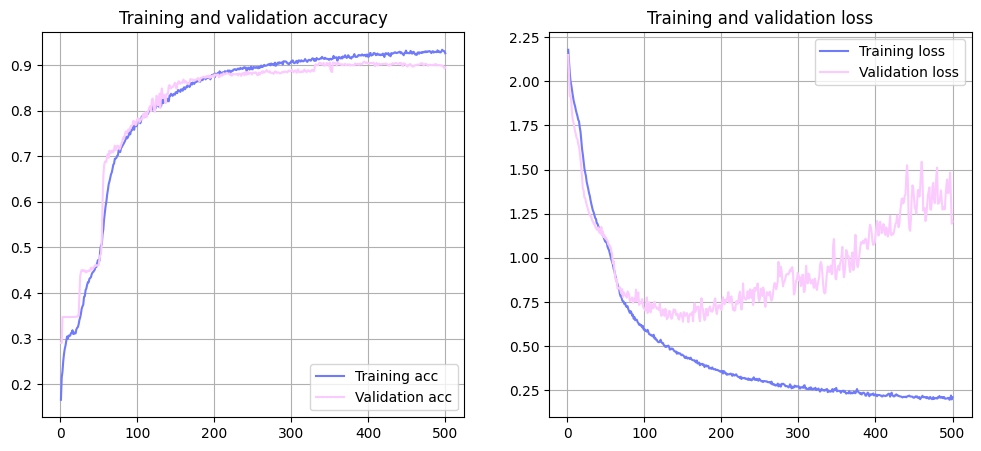

In [25]:
plot_history(history)

In [26]:
# setting a custom colormap
from matplotlib.colors import LinearSegmentedColormap
colors = ['#ffffff', '#fbcbff', '#707bfb']
cmap = LinearSegmentedColormap.from_list('mycmap', colors)

In [27]:
def plot_confusion_matrix(matrix, fmt=''):
  '''
  Accepts a confusion matrix and a format param
  Plots the matrix as a heatmap
  Returns nothing

  '''
  plt.figure(figsize=(9, 8))
  sns.heatmap(matrix, annot=True, 
              cmap=cmap, 
              fmt=fmt, 
              xticklabels=emotions_to_labels.keys(), 
              yticklabels=emotions_to_labels.keys())
  plt.ylabel('True labels')
  plt.xlabel('Predicted labels')
  plt.show()

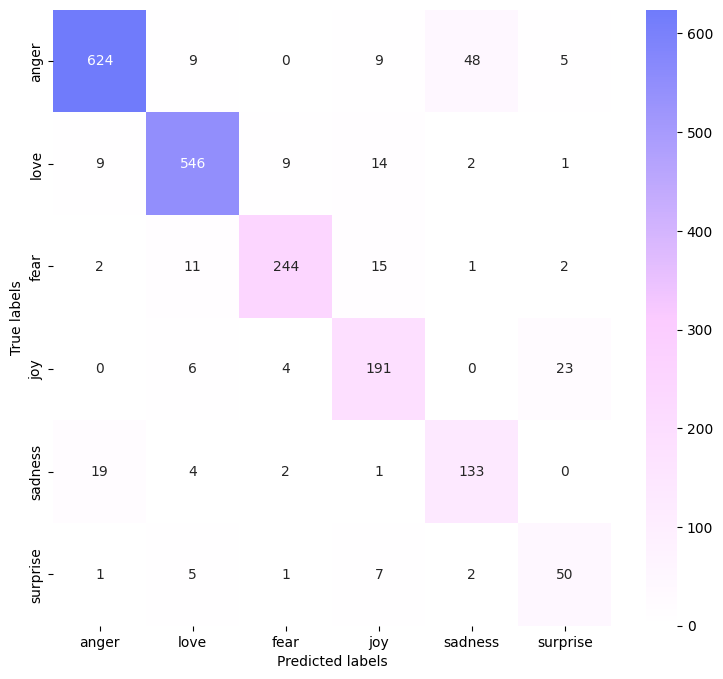

In [28]:
matrix = metrics.confusion_matrix(test_label_seq, y_pred)
plot_confusion_matrix(matrix)

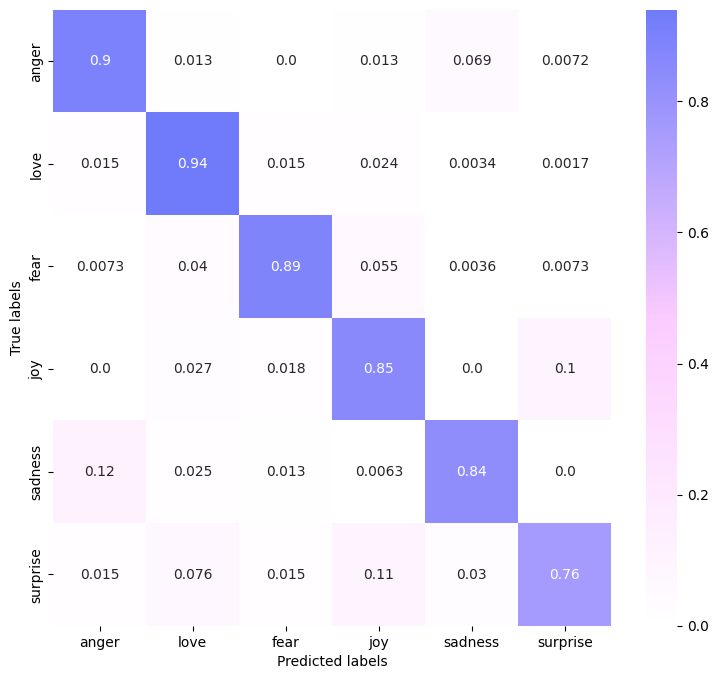

In [29]:
# create new confusion matrix
# where values are normed by row
matrix_new = np.zeros(matrix.shape)

for row in range(len(matrix)):
  sum = np.sum(matrix[row])
  for element in range(len(matrix[row])):
    matrix_new[row][element] = matrix[row][element] / sum

plot_confusion_matrix(matrix_new, fmt='.2')

In [ ]:
def plot_result(result):
    sns.barplot(x = 'Category', y = 'Confidence', data = result)
    plt.xlabel('Categories', size=14)
    plt.ylabel('Confidence', size=14)
    plt.title('Emotion Classification', size=16)

In [ ]:
from sklearn import preprocessing
le = preprocessing.OneHotEncoder()
y_train= le.fit_transform(np.array(train['Sentiment']).reshape(-1, 1)).toarray()
y_test= le.fit_transform(np.array(test['Sentiment']).reshape(-1, 1)).toarray()
y_val= le.fit_transform(np.array(validation['Sentiment']).reshape(-1, 1)).toarray()

In [ ]:

def predict(texts):
    '''
    Accepts an array of texts (strings)
    Prints the sentence and the corresponding labels (emotions)
    Returns a DataFrame with the predicted labels and confidences for all emotions
    '''

    # Define the threshold for label activation
    threshold = 0.5

    texts_prepr = [text_preprocess(t) for t in texts]
    sequences = tokenizer.texts_to_sequences(texts_prepr)
    pad = pad_sequences(sequences, maxlen=MAX_LEN)

    predictions = model.predict(pad)

    # Initialize a list of all possible emotions
    all_emotions = list(labels_to_emotions.values())

    # Create a list to store individual DataFrames for each text
    result_dfs = []

    for i, preds in enumerate(predictions):
        # Create a dictionary to store the confidences for all emotions
        confidence_dict = {emotion: 0.0 for emotion in all_emotions}

        # Find labels where the probability exceeds the threshold
        active_labels = [idx for idx, prob in enumerate(preds) if prob >= threshold]
        predicted_emotions = [labels_to_emotions[idx] for idx in active_labels]

        # Update the confidence_dict with the confidences for the predicted emotions
        for idx, prob in enumerate(preds):
            emotion = labels_to_emotions[idx]
            confidence_dict[emotion] = round(prob*100, 2)

        # Create a DataFrame for the current text
        text_df = pd.DataFrame({'Text': [texts[i]], **confidence_dict})

        # Append the DataFrame to the list
        result_dfs.append(text_df)

        print(f'\'{texts[i]}\' --> {predicted_emotions}')

    # Concatenate all individual DataFrames into one result DataFrame
    result = pd.concat(result_dfs, ignore_index=True)

    return result
 

In [ ]:
from pyplutchik import plutchik

# Test the predict function with a list of texts
test_texts = ['disgusted with his face that everyone was so mad at him']
result_df = predict(test_texts)
print(result_df)


In [ ]:

text_column = result_df['Text']
emotion_columns = result_df.drop(columns=['Text'])
score = 0

emotion_list = emotion_columns.to_dict(orient='records')


emotions = {}
for i, text in enumerate(text_column):
    emotions[text] = emotion_list[i]

combined_emotions = {}


for emotion_dict in emotion_list:
    for emotion, confidence in emotion_dict.items():
        if emotion not in combined_emotions:
            combined_emotions[emotion] = confidence / 100.0
        else:
            combined_emotions[emotion] += confidence / 100.0


num_texts = len(emotion_list)
for emotion in combined_emotions:
    combined_emotions[emotion] /= num_texts

# combined_emotions['anticipation'] = 0.0

print(combined_emotions)
plutchik(combined_emotions)



In [ ]:
model.save('BI-LSTM_Gerard')

# Suggestions
---
- Try using sentence transformers instead of word to vectors.
- Try using bigram and trigram instead of just unigrams.
- Extend the training.
- Check the validation and testing dataset there might be some data leaks.
- Beat Occam's Razor, no matter how advance your model is, if it does not provide a better advantage over simple models, it is still not useful.